In [74]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import os
import matplotlib.pyplot as plt
import random

num_classes = 43
alphabet = 'абвгдеёжзийклмнопрстуфхцчшщъыьэюя0123456789'
classes_to_idx = {

}


for i, char in enumerate(alphabet):
    classes_to_idx[char] = i

idx_to_classes = None

In [75]:
def create_image_array(text, font_path, image_size, font_size):
    image = Image.new('1', image_size, color='white')
    draw = ImageDraw.Draw(image)
    font = ImageFont.truetype(font_path, font_size)

    text_bbox = draw.textbbox((0, 0), text, font=font)
    text_width = text_bbox[2] - text_bbox[0]
    text_height = text_bbox[3] - text_bbox[1]

    x = (image_size[0] - text_width) / 2
    y = (image_size[1] - text_height) / 2

    draw.text((x, y), text, fill='black', font=font)

    image_array = np.array(image)
    return image_array



def generate_dataset(fonts_folder_train, fonts_folder_test, font_size):
    image_size = (5 * font_size, 4 * font_size)
    images_train = []
    images_test = []
    labels_train = []
    labels_test = []

    for char in alphabet:
        for font_file in os.listdir(fonts_folder_train):
            font_path = os.path.join(fonts_folder_train, font_file)
            if font_file.endswith(('.ttf', '.otf')):
                image_array = create_image_array(char, font_path, image_size, font_size)
                images_train.append(image_array)
                labels_train.append(classes_to_idx[char])


        for font_file in os.listdir(fonts_folder_test):
            font_path = os.path.join(fonts_folder_test, font_file)
            if font_file.endswith(('.ttf', '.otf')):
                image_array = create_image_array(char, font_path, image_size, font_size)
                images_test.append(image_array)
                labels_test.append(classes_to_idx[char])

    return images_train, images_test, labels_train, labels_test

In [76]:
fonts_folder_train = "fonts_train"
fonts_folder_test = "fonts_test"
font_size = 12

dataset_train, dataset_test, labels_train, labels_test = generate_dataset(fonts_folder_train, fonts_folder_test, font_size)
combined_train = list(zip(dataset_train, labels_train))
combined_test = list(zip(dataset_test, labels_test))
random.shuffle(combined_train)
random.shuffle(combined_test)
dataset_train, labels_train = zip(*combined_train)
dataset_test, labels_test = zip(*combined_test)

dataset_train, dataset_test, labels_train, labels_test = np.array(dataset_train), np.array(dataset_test), np.array(labels_train), np.array(labels_test)

dataset_train = np.logical_not(dataset_train)
dataset_test = np.logical_not(dataset_test)

dataset_train = dataset_train.astype(int)
dataset_test = dataset_test.astype(int)

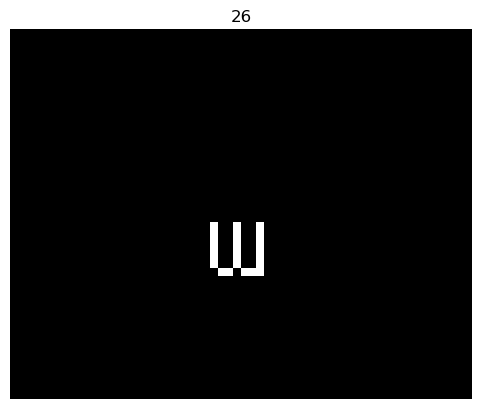

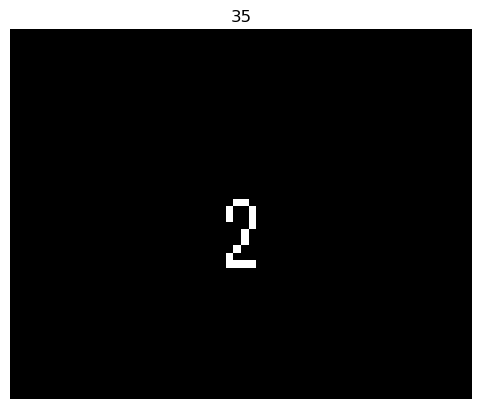

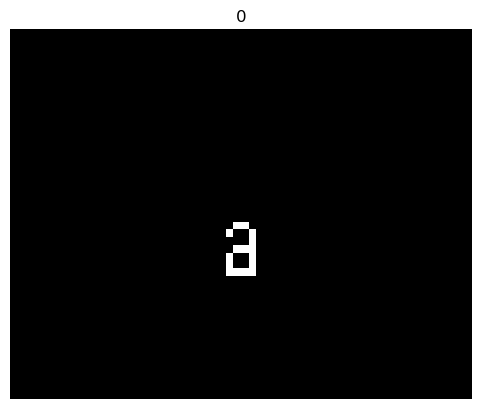

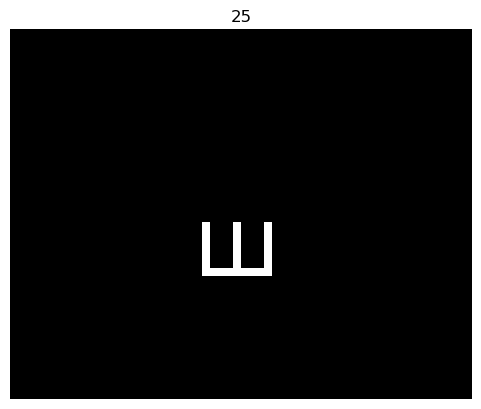

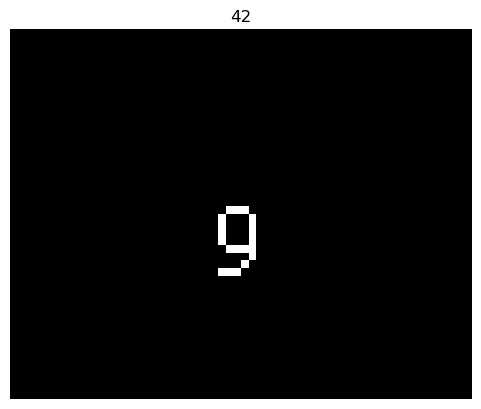

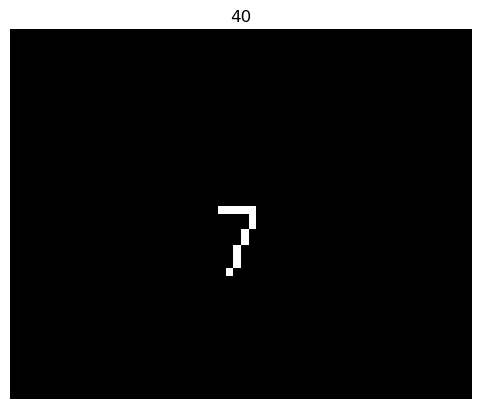

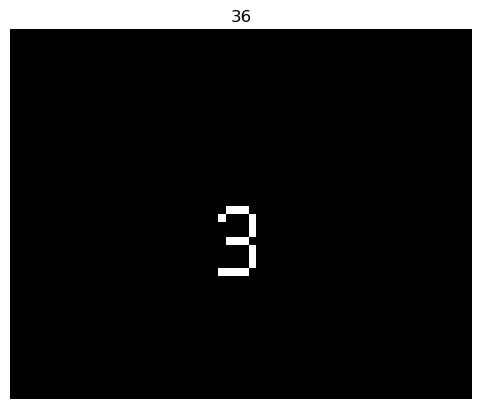

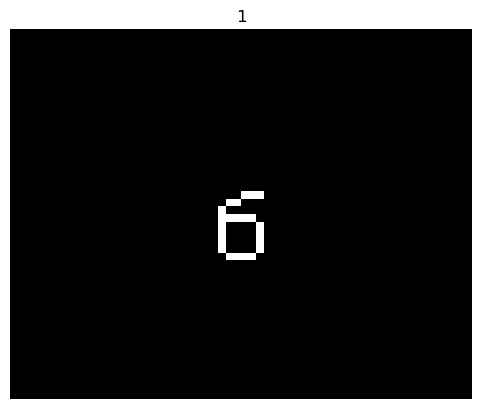

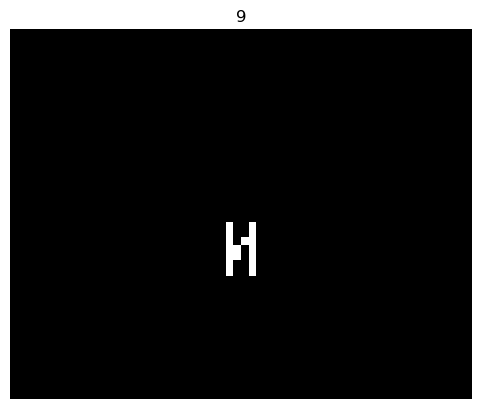

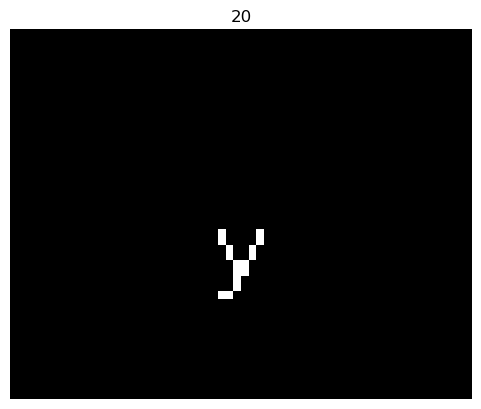

In [77]:
for i in range(0, 10):
    plt.imshow(dataset_train[i], cmap='gray')
    plt.title(labels_train[i])
    plt.axis('off')
    plt.show()

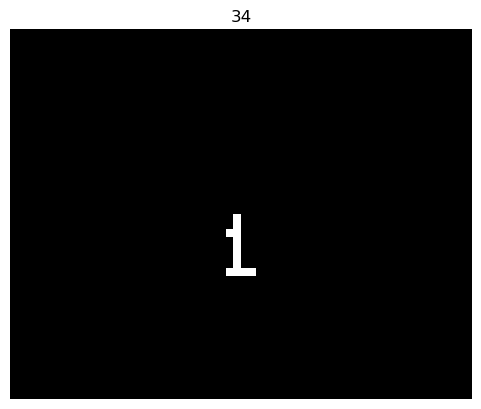

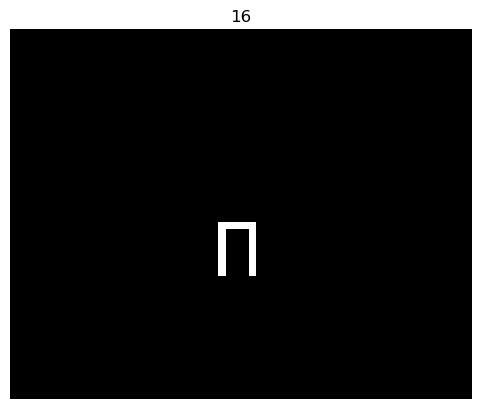

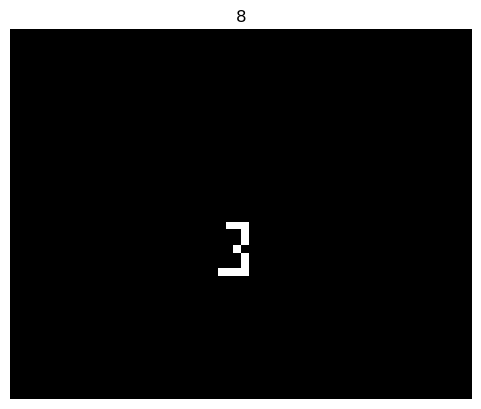

In [78]:
for i in range(0, 3):
    plt.imshow(dataset_test[i], cmap='gray')
    plt.title(labels_test[i])
    plt.axis('off')
    plt.show()

In [79]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def ReLU(x):
    return np.maximum(0, x)

def linear(x):
    return x

def tanh(x):
    return np.tanh(x)

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

def tanh_derivative(x):
    return  1 - tanh(x) ** 2

def linear_derivative(x):
    return 1

def ReLU_derivative(x):
    return int((x > 0))

def MSE(prediction, label):
    return sum((prediction[i] - label[i]) ** 2 for i in range(len(prediction)))

class Perceptron:
    def __init__(self, input_size, num_neurons, activation, activation_derivative):
        self.input_size = input_size
        self.activation = activation
        self.activation_derivative = activation_derivative
        self.weights = np.zeros(shape=(num_neurons, input_size + 1))

    def train(self, training_data, test_data, train_labels, test_labels, epochs, learning_rate):
        errors_train = []
        errors_test = []
        accuracy_train = []
        accuracy_test = []

        for j in range(epochs):
            running_error = 0
            run_acc = 0
            for i in range(len(training_data)):
                inputs = np.insert(training_data[i], 0, 1)
                label = train_labels[i]
                prediction = self.predict(inputs)
                error = prediction - label
                delta = error * self.activation_derivative(np.dot(self.weights, inputs))

                pred = np.argmax(prediction)
                if pred == np.argmax(label):
                    run_acc += 1
                running_error += MSE(prediction, label)

                self.weights -= learning_rate * np.outer(delta, inputs)
            running_error /= len(training_data)
            errors_train.append(running_error)
            accuracy_train.append(run_acc / len(training_data))

            running_error = 0
            run_acc = 0
            for i in range(len(test_data)):
                inputs = np.insert(test_data[i], 0, 1)
                label = test_labels[i]
                prediction = self.predict(inputs)

                pred  = np.argmax(prediction)
                if pred == np.argmax(label):
                    run_acc += 1
                running_error += MSE(prediction, label)

            running_error /= len(test_data)
            errors_test.append(running_error)
            accuracy_test.append(run_acc / len(test_data))

        return errors_train, errors_test, accuracy_train, accuracy_test

    def predict(self, inputs):
        summation = np.dot(self.weights, inputs)
        return self.activation(summation)

In [80]:
perceptron_sigmoid = Perceptron(5 * font_size * 4 * font_size, num_classes, sigmoid, sigmoid_derivative)
perceptron_tanh = Perceptron(5 * font_size * 4 * font_size, num_classes, tanh, tanh_derivative)
perceptron_linear = Perceptron(5 * font_size * 4 * font_size, num_classes, linear, linear_derivative)
perceptron_ReLU = Perceptron(5 * font_size * 4 * font_size, num_classes, ReLU, ReLU_derivative)

dataset_train_vector = dataset_train.reshape(len(dataset_train), 5 * font_size * 4 * font_size)
dataset_test_vector = dataset_test.reshape(len(dataset_test), 5 * font_size * 4 * font_size)
labels_train_onehot = [[1 if i == label else 0 for i in range(num_classes)] for label in labels_train]
labels_test_onehot = [[1 if i == label else 0 for i in range(num_classes)] for label in labels_test]
labels_train_onehot_1 = [[1 if i == label else -1 for i in range(num_classes)] for label in labels_train]
labels_test_onehot_1 = [[1 if i == label else -1 for i in range(num_classes)] for label in labels_test]


epoch_num = 100
learning_rate = 0.1

errors_train_sigmoid, errors_test_sigmoid, accuracy_train_sigmoid, accuracy_test_sigmoid = perceptron_sigmoid.train(dataset_train_vector, dataset_test_vector, labels_train_onehot, labels_test_onehot, epoch_num, learning_rate)

errors_train_tanh, errors_test_tanh, accuracy_train_tanh, accuracy_test_tanh = perceptron_tanh.train(dataset_train_vector, dataset_test_vector, labels_train_onehot_1, labels_test_onehot_1, epoch_num, learning_rate)

errors_train_linear, errors_test_linear, accuracy_train_linear, accuracy_test_linear = perceptron_linear.train(dataset_train_vector, dataset_test_vector, labels_train_onehot_1, labels_test_onehot_1, epoch_num, learning_rate)

errors_train_ReLU , errors_test_ReLU , accuracy_train_ReLU , accuracy_test_ReLU  = perceptron_linear.train(dataset_train_vector, dataset_test_vector, labels_train_onehot, labels_test_onehot, epoch_num, learning_rate)

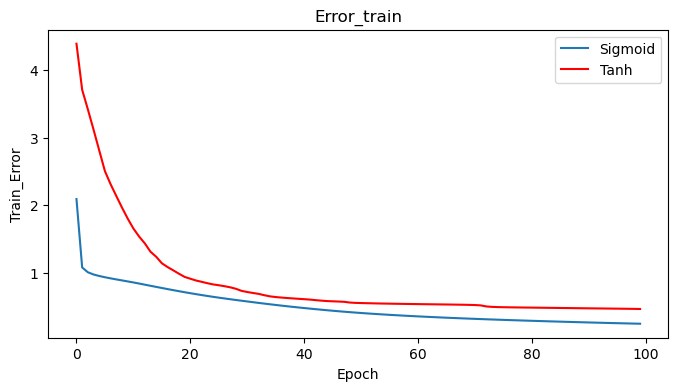

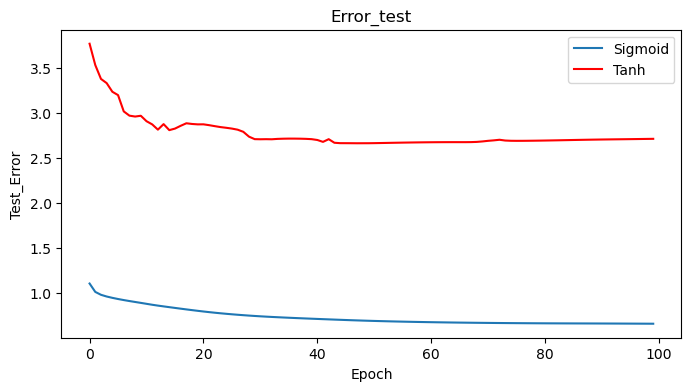

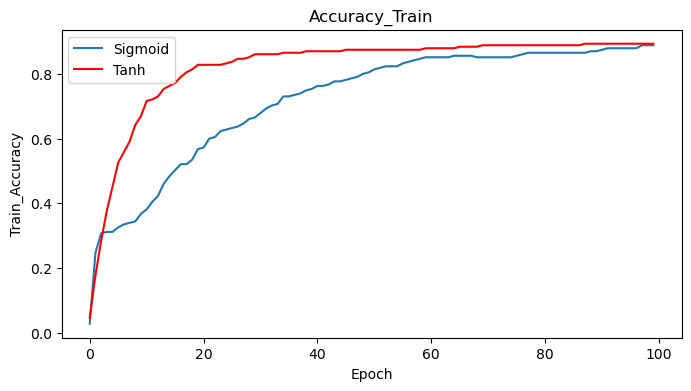

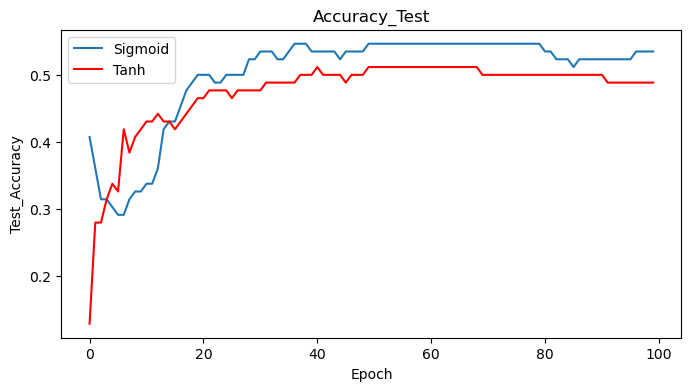

In [81]:
plt.figure(figsize=(8, 4))
plt.plot(errors_train_sigmoid, label='Sigmoid')
plt.plot(errors_train_tanh, label='Tanh', color='red')
#plt.plot(errors_train_linear, label='Linear', color='green')
#plt.plot(errors_train_ReLU, label='ReLU', color='yellow')
plt.xlabel('Epoch')
plt.ylabel('Train_Error')
plt.legend()
plt.title('Error_train')
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(errors_test_sigmoid, label='Sigmoid')
plt.plot(errors_test_tanh, label='Tanh', color='red')
#plt.plot(errors_test_linear, label='Linear', color='green')
#plt.plot(errors_test_ReLU, label='ReLU', color='yellow')
plt.xlabel('Epoch')
plt.ylabel('Test_Error')
plt.legend()
plt.title('Error_test')
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(accuracy_train_sigmoid, label='Sigmoid')
plt.plot(accuracy_train_tanh, label='Tanh', color='red')
#plt.plot(accuracy_train_linear, label='Linear', color='green')
#plt.plot(accuracy_train_ReLU, label='ReLU', color='yellow')
plt.xlabel('Epoch')
plt.ylabel('Train_Accuracy')
plt.legend()
plt.title('Accuracy_Train')
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(accuracy_test_sigmoid, label='Sigmoid')
plt.plot(accuracy_test_tanh, label='Tanh', color='red')
#plt.plot(accuracy_test_linear, label='Linear', color='green')
#plt.plot(accuracy_test_ReLU, label='ReLU', color='yellow')
plt.xlabel('Epoch')
plt.ylabel('Test_Accuracy')
plt.legend()
plt.title('Accuracy_Test')
plt.show()

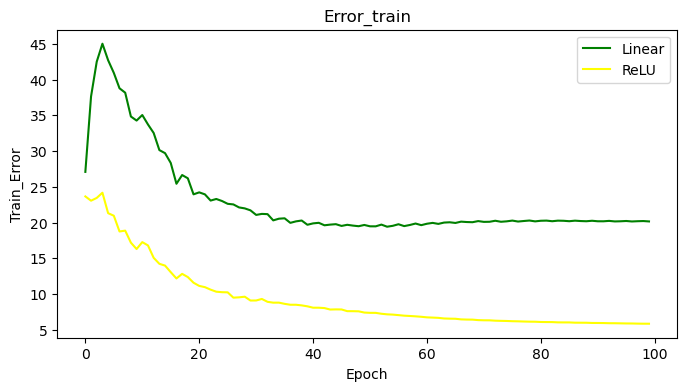

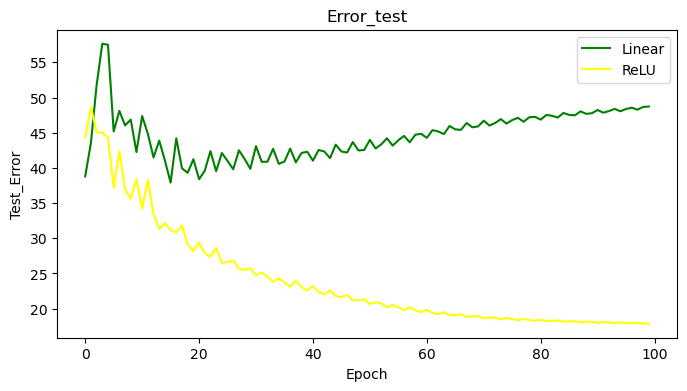

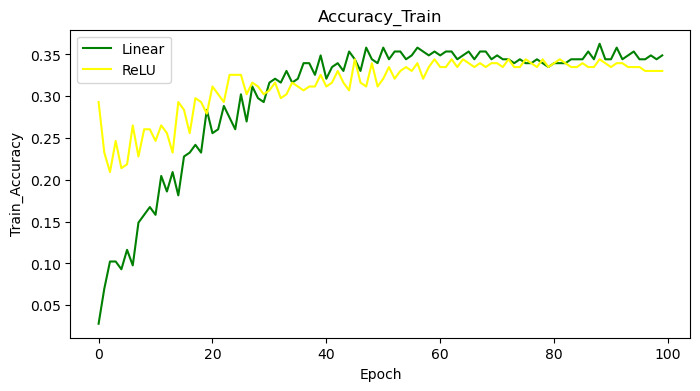

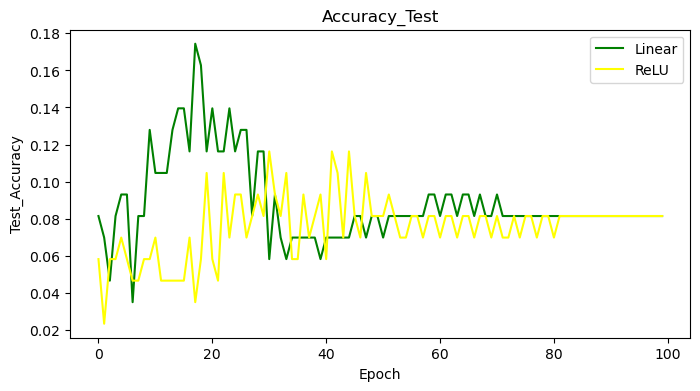

In [82]:
plt.figure(figsize=(8, 4))
plt.plot(errors_train_linear, label='Linear', color='green')
plt.plot(errors_train_ReLU, label='ReLU', color='yellow')
plt.xlabel('Epoch')
plt.ylabel('Train_Error')
plt.legend()
plt.title('Error_train')
plt.show()

plt.figure(figsize=(8, 4))

plt.plot(errors_test_linear, label='Linear', color='green')
plt.plot(errors_test_ReLU, label='ReLU', color='yellow')
plt.xlabel('Epoch')
plt.ylabel('Test_Error')
plt.legend()
plt.title('Error_test')
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(accuracy_train_linear, label='Linear', color='green')
plt.plot(accuracy_train_ReLU, label='ReLU', color='yellow')
plt.xlabel('Epoch')
plt.ylabel('Train_Accuracy')
plt.legend()
plt.title('Accuracy_Train')
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(accuracy_test_linear, label='Linear', color='green')
plt.plot(accuracy_test_ReLU, label='ReLU', color='yellow')
plt.xlabel('Epoch')
plt.ylabel('Test_Accuracy')
plt.legend()
plt.title('Accuracy_Test')
plt.show()